In [22]:
'''This script is used to train a random forest regression model with the second training scheme I'm considering; the 
one that uses all previous data and aggregated yearly metrics for each beneficiary year and that includes 
target encoding.'''

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from utils import (
    describe_dataframe, df_train_test, graph_results, reg_train_eval
)

In [23]:
main = pd.read_csv("../data/combo_data.csv")
main

#Identify relevant columns
select_cols = ["LOS" ,
               "YR",  
               "PRNCPAL_DGNS_CD", 
               "CLM_IP_ADMSN_TYPE_CD", 
               "ER_flag", 
               "STATE_CODE", 
               "COUNTY_CD", 
               "BENE_RACE_CD", 
               "ESRD_IND",
               "Age", 
               "TOT_RX_CST_AMT", 
               "NUM_DIAG",
               "SEX_IDENT_CD"]

workingdf_te = main[select_cols].copy()

prncpl_diag_col = pd.DataFrame(data = {"PRNCPL_DGNS_CD": workingdf_te.loc[:,"PRNCPAL_DGNS_CD"]})

print(prncpl_diag_col.shape)

los_col = workingdf_te.loc[:,"LOS"]

print(los_col.shape)

encoder = TargetEncoder(categories='auto', target_type='continuous', smooth='auto', cv=5, random_state=42)

workingdf_te["PRNCPAL_DGNS_CD"] = encoder.fit_transform(prncpl_diag_col, los_col)

workingdf_te = workingdf_te.assign(ESRD_IND = workingdf_te["ESRD_IND"].map({"Y": 1, "0" : 0}))

wdf_rest_te = workingdf_te[workingdf_te["YR"] < 2022]
wdf_2022_te = workingdf_te[workingdf_te["YR"] >= 2022]

ohe = OneHotEncoder(sparse_output=False)

ohe.fit(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                  'STATE_CODE', 
                  'BENE_RACE_CD', 
                  "SEX_IDENT_CD"]])

ohe_df_rest_te = pd.DataFrame(data = ohe.transform(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                          'STATE_CODE', 
                                                          'BENE_RACE_CD',
                                                          "SEX_IDENT_CD"]]), 
             columns=ohe.get_feature_names_out(wdf_rest_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                         'STATE_CODE', 
                                                         'BENE_RACE_CD',
                                                         "SEX_IDENT_CD"]].columns))

ohe.fit(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                  'STATE_CODE', 
                  'BENE_RACE_CD', 
                  "SEX_IDENT_CD"]])
ohe_df_2022_te = pd.DataFrame(data = ohe.transform(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                          'STATE_CODE', 
                                                          'BENE_RACE_CD',
                                                          "SEX_IDENT_CD"]]), 
             columns=ohe.get_feature_names_out(wdf_2022_te[['CLM_IP_ADMSN_TYPE_CD', 
                                                         'STATE_CODE', 
                                                         'BENE_RACE_CD',
                                                         "SEX_IDENT_CD"]].columns))

#drop year, county code, all one hot encoded vars 
wdf_rest_te = wdf_rest_te.drop(columns=["YR", 
                                  "COUNTY_CD", 
                                  'CLM_IP_ADMSN_TYPE_CD', 
                                  'STATE_CODE', 
                                  'BENE_RACE_CD',
                                  "SEX_IDENT_CD"])
wdf_2022_te = wdf_2022_te.drop(columns=["YR", 
                                  "COUNTY_CD", 
                                  'CLM_IP_ADMSN_TYPE_CD', 
                                  'STATE_CODE', 
                                  'BENE_RACE_CD',
                                  "SEX_IDENT_CD"])

wdf_rest_te = pd.concat([wdf_rest_te.reset_index(drop=True), ohe_df_rest_te.reset_index(drop=True)], axis=1)
wdf_2022_te = pd.concat([wdf_2022_te.reset_index(drop=True), ohe_df_2022_te.reset_index(drop=True)], axis=1)

reg_mod_metrics = {"Test":{},
                   "Train":{}}

predictions = {}

(20867, 1)
(20867,)


In [24]:
X_train_rest_te, X_test_rest_te, y_train_rest_te, y_test_rest_te = df_train_test(wdf_rest_te, "LOS", 0.2)

X_train_2022_te, X_test_2022_te, y_train_2022_te, y_test_2022_te = df_train_test(wdf_2022_te, "LOS", 0.2)

In [25]:
reg_train_eval(RandomForestRegressor(n_estimators=100, random_state=42),
               None,
               X_train_rest_te,
               y_train_rest_te,
               X_test_2022_te,
               y_test_2022_te,
               reg_mod_metrics,
               predictions,
               year = "rest_train-2022test-te")

reg_mod_metrics

{'Test': {'RandomForestRegressor - NoneType - rest_train-2022test-te': {'RMSLE': 0.292312793087425,
   'R2': 0.48786033580176014,
   'MAE': 0.7268016205402569,
   'MSE': 6.767655029019409}},
 'Train': {'RandomForestRegressor - NoneType - rest_train-2022test-te': {'RMSLE': 0.13835712847835815,
   'R2': 0.9231600713943726,
   'MAE': 0.23596542894935751,
   'MSE': 0.7250110240728559}}}

In [ ]:
# Grid search above model
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 6],
    'criterion': ['squared_error']  # 'mse' is deprecated, use 'squared_error'
}

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# Instantiate model
rf_mod = RandomForestRegressor(random_state=42)

# Define GridSearchCV with multiple scoring metrics
grid_search = GridSearchCV(
    estimator=rf_mod, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    scoring='r2' # Grid search will optimize for r_squared
)

grid_search.fit(X_train_rest_te, y_train_rest_te)

KeyError: 'mean_test_RMSLE'

In [27]:
# Best parameters and scores
best_params = grid_search.best_params_
best_r_squared = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best R-squared: {best_r_squared}")

Best Parameters: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 300}
Best R-squared: 0.5450439968834677


In [31]:
# Evaluate on the test set
best_model = grid_search.best_estimator_
reg_train_eval(best_model,
               None,
               X_train_rest_te,
               y_train_rest_te,
               X_test_2022_te,
               y_test_2022_te,
               reg_mod_metrics,
               predictions,
               year = "rest_train-2022test-te-gridcv_best")

reg_mod_metrics['Test']

{'RandomForestRegressor - NoneType - rest_train-2022test-te': {'RMSLE': 0.2984610220111602,
  'R2': 0.48054203531776596,
  'MAE': 0.7291129630267014,
  'MSE': 6.864362502657316},
 'RandomForestRegressor - NoneType - rest_train-2022test-te-gridcv_best': {'RMSLE': 0.2984610220111602,
  'R2': 0.48054203531776596,
  'MAE': 0.7291129630267014,
  'MSE': 6.864362502657316}}

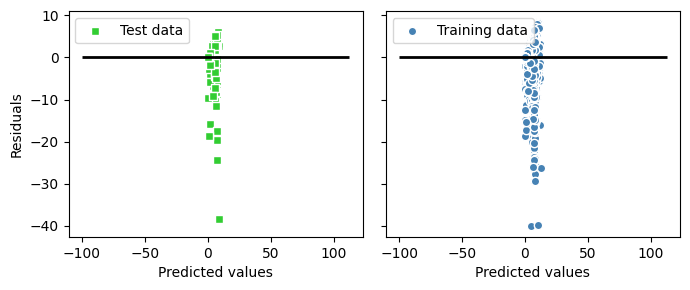

In [32]:
# Graph best results
graph_results(predictions["RandomForestRegressor - NoneType - rest_train-2022test-te-gridcv_best"]["y_predict_train"], 
              predictions["RandomForestRegressor - NoneType - rest_train-2022test-te-gridcv_best"]["y_predict"], 
              y_train_rest_te, 
              y_test_2022_te)